In [ ]:
#Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install required package and libraries

In [ ]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git
import os
import numpy as np
import cv2
import xml.etree.ElementTree as ET
import shutil
import random
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from ultralytics import YOLOv10
import glob
import yaml
from IPython.display import Image, display
HOME = os.getcwd()
print(HOME)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
/content


Convert dataset from COCO annotation format to YOLO annotation format

In [ ]:
#Define format conversion function
def convert_voc_to_yolo(xml_file, txt_file, image_width, image_height):
    try:
      tree = ET.parse(xml_file)
      root = tree.getroot()

      with open(txt_file, 'w') as f:
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            class_id = class_name_to_id[class_name]  # Convert class name to class ID

            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            # Convert from Pascal VOC format to YOLO format
            x_center = (xmin + xmax) / 2.0 / image_width
            y_center = (ymin + ymax) / 2.0 / image_height
            width = (xmax - xmin) / image_width
            height = (ymax - ymin) / image_height

            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
    #Print keyerror if exist
    except KeyError as e:
        print(f"KeyError: {e} in file: {xml_file}")
    except Exception as e:
        print(f"An error occurred: {e} in file: {xml_file}")

def create_yolo_annotations(xml_folder, output_folder, image_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for xml_file in os.listdir(xml_folder):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(xml_folder, xml_file)
            image_name = os.path.splitext(xml_file)[0] + '.jpg'
            image_path = os.path.join(image_folder, image_name)


            image_width, image_height = get_image_size(image_path)  # Implement this function to get image size

            txt_file = os.path.join(output_folder, os.path.splitext(xml_file)[0] + '.txt')
            convert_voc_to_yolo(xml_path, txt_file, image_width, image_height)

def get_image_size(image_path):

    image = cv2.imread(image_path)
    return image.shape[1], image.shape[0]

# target folder paths
xml_folder = '/content/drive/MyDrive/GC-10-DET/annotation'
output_folder = '/content/drive/MyDrive/GC-10-DET/YOLO_annotation'
image_folder = '/content/drive/MyDrive/GC-10-DET/images'

# Assign class names and corresponding IDs
class_name_to_id = {
    '1_chongkong': 1,
    '2_hanfeng': 2,
    '3_yueyawan': 3,
    '4_shuiban': 4,
    '5_youban': 5,
    '6_siban': 6,
    '7_yiwu': 7,
    '8_yahen': 8,
    '9_zhehen': 9,
    #Both '10_yaozhe' and '10_yaozhed' belongs to class 10, probably due to typo error.
    '10_yaozhe': 10,
    '10_yaozhed': 10
}

create_yolo_annotations(xml_folder, output_folder, image_folder)

#Adjusting class index to begin from 0.
annotation_path = '/content/drive/MyDrive/GC-10-DET/YOLO_annotation'

# Function to adjust class indices to start from 0.
def adjust_annotations(annotation_path):
    for filename in os.listdir(annotation_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(annotation_path, filename)
            with open(file_path, 'r') as file:
                lines = file.readlines()
            with open(file_path, 'w') as file:
                for line in lines:
                    parts = line.strip().split()
                    parts[0] = str(int(parts[0]) - 1)  # Adjust class index
                    file.write(' '.join(parts) + '\n')

# Adjust annotations
adjust_annotations(annotation_path)


Split dataset into Train, test, and validation set.

In [ ]:
#Define data splitting function
def split_data_with_annotations(source_dir, annotation_dir, train_dir, val_dir, test_dir,
                                train_anno_dir, val_anno_dir, test_anno_dir,
                                train_split=0.7, val_split=0.15, test_split=0.15):

    # Ensure the destination directories exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(train_anno_dir, exist_ok=True)
    os.makedirs(val_anno_dir, exist_ok=True)
    os.makedirs(test_anno_dir, exist_ok=True)

    # Get all image file names from the source directory
    image_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f)) and f.endswith('.jpg')]

    # Shuffle the image files
    random.shuffle(image_files)

    # Calculate the split indices
    train_idx = int(len(image_files) * train_split)
    val_idx = train_idx + int(len(image_files) * val_split)

    # Split the images
    train_files = image_files[:train_idx]
    val_files = image_files[train_idx:val_idx]
    test_files = image_files[val_idx:]

    # Copy the files and their corresponding annotations to their respective directories
    for file_name in train_files:
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(train_dir, file_name))
        annotation_file = file_name.replace('.jpg', '.txt')
        annotation_path = os.path.join(annotation_dir, annotation_file)
        if os.path.exists(annotation_path):
            shutil.copy(annotation_path, os.path.join(train_anno_dir, annotation_file))

    for file_name in val_files:
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(val_dir, file_name))
        annotation_file = file_name.replace('.jpg', '.txt')
        annotation_path = os.path.join(annotation_dir, annotation_file)
        if os.path.exists(annotation_path):
            shutil.copy(annotation_path, os.path.join(val_anno_dir, annotation_file))

    for file_name in test_files:
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(test_dir, file_name))
        annotation_file = file_name.replace('.jpg', '.txt')
        annotation_path = os.path.join(annotation_dir, annotation_file)
        if os.path.exists(annotation_path):
            shutil.copy(annotation_path, os.path.join(test_anno_dir, annotation_file))

    print(f"Training set: {len(train_files)} images")
    print(f"Validation set: {len(val_files)} images")
    print(f"Test set: {len(test_files)} images")

#Define folder path
source_directory = '/content/drive/MyDrive/GC-10-DET/images'
annotation_directory = '/content/drive/MyDrive/GC-10-DET/YOLO_annotation'
train_directory = '/content/drive/MyDrive/GC-10-DET/train/images'
train_annotation_directory = '/content/drive/MyDrive/GC-10-DET/train/labels'
validation_directory = '/content/drive/MyDrive/GC-10-DET/val/images'
validation_annotation_directory = '/content/drive/MyDrive/GC-10-DET/val/labels'
test_directory = '/content/drive/MyDrive/GC-10-DET/test/images'
test_annotation_directory = '/content/drive/MyDrive/GC-10-DET/test/labels'

#Execute data splitting function
split_data_with_annotations(source_directory, annotation_directory,
                            train_directory, validation_directory, test_directory,
                            train_annotation_directory, validation_annotation_directory, test_annotation_directory)

Training set: 1610 images
Validation set: 345 images
Test set: 345 images


Perform data augmentation on training set

In [ ]:
# Define the augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.2),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['labels'], min_visibility=0.2))

# Function to augment image and bounding boxes in YOLO format
def augment_image_and_bboxes_yolo(image_path, bboxes, labels,images_output_dir, annotations_output_dir, aug_pipeline, num_augmentations=2):
    image = cv2.imread(image_path)
    image_name = os.path.basename(image_path).split('.')[0]

    for i in range(num_augmentations):
        augmented = aug_pipeline(image=image, bboxes=bboxes, labels=labels)
        augmented_image = augmented["image"]
        augmented_bboxes = augmented["bboxes"]
        augmented_labels = augmented["labels"]

        # Convert the image to the correct format and save it
        augmented_image= augmented_image.permute(1, 2, 0).cpu().numpy()
        augmented_image_path = os.path.join(images_output_dir, f"{image_name}_aug_{i}.jpg")
        cv2.imwrite(augmented_image_path, augmented_image)

        # Save augmented bounding boxes in YOLO format
        augmented_bboxes_path = os.path.join(annotations_output_dir, f"{image_name}_aug_{i}.txt")
        with open(augmented_bboxes_path, 'w') as f:
            for bbox, label in zip(augmented_bboxes, augmented_labels):
                x_center, y_center, bbox_width, bbox_height = bbox
                f.write(f"{label} {x_center} {y_center} {bbox_width} {bbox_height}\n")

        print(f"Saved augmented image and bboxes: {augmented_image_path}, {augmented_bboxes_path}")

# Path where images and annotations are stored
images_dir = '/content/drive/MyDrive/GC-10-DET/train/images'
annotations_dir = '/content/drive/MyDrive/GC-10-DET/train/labels'
images_output_dir = '/content/drive/MyDrive/GC-10-DET/train/images'
annotations_output_dir = '/content/drive/MyDrive/GC-10-DET/train/labels'

# List all images
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

# Augment each image
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    annotation_path = os.path.join(annotations_dir, image_file.replace('.jpg', '.txt'))
    # Check if the annotation file exists
    if not os.path.exists(annotation_path):
        print(f"Annotation file not found, skipping: {annotation_path}")
        continue

    # Read annotations in YOLO format
    bboxes = []
    labels = []
    with open(annotation_path, 'r') as f:
        for line in f.readlines():
            label, x_center, y_center, width, height = map(float, line.strip().split())
            labels.append(int(label))
            bboxes.append([x_center, y_center, width, height])  # Keep in YOLO format
    #Execute augmentation function
    augment_image_and_bboxes_yolo(image_path, bboxes, labels,images_output_dir, annotations_output_dir, augmentation_pipeline)

Saved augmented image and bboxes: /content/drive/MyDrive/GC-10-DET/train/images/img_07_425503000_00062_aug_0.jpg, /content/drive/MyDrive/GC-10-DET/train/labels/img_07_425503000_00062_aug_0.txt
Saved augmented image and bboxes: /content/drive/MyDrive/GC-10-DET/train/images/img_07_425503000_00062_aug_1.jpg, /content/drive/MyDrive/GC-10-DET/train/labels/img_07_425503000_00062_aug_1.txt
Saved augmented image and bboxes: /content/drive/MyDrive/GC-10-DET/train/images/img_02_4406772100_00305_aug_0.jpg, /content/drive/MyDrive/GC-10-DET/train/labels/img_02_4406772100_00305_aug_0.txt
Saved augmented image and bboxes: /content/drive/MyDrive/GC-10-DET/train/images/img_02_4406772100_00305_aug_1.jpg, /content/drive/MyDrive/GC-10-DET/train/labels/img_02_4406772100_00305_aug_1.txt
Saved augmented image and bboxes: /content/drive/MyDrive/GC-10-DET/train/images/img_07_4406743300_00104_aug_0.jpg, /content/drive/MyDrive/GC-10-DET/train/labels/img_07_4406743300_00104_aug_0.txt
Saved augmented image and bbo

Model training

In [ ]:
#Define data.yaml file for training
data = {
    'path': '/content/drive/MyDrive/GC-10-DET', #Dataset path
    'train': 'train/images',#Training data path
    'val': 'val/images',#Validation data path
    'test': 'test/images',# testing data path
    'nc': 10,# number of defect class
    'names': ['punching_hole', 'welding_line', 'crescent_gap', 'water_spot', 'oil_spot',
              'silk_spot', 'inclusion', 'rolled_pit', 'crease', 'waist_folding'
              ]
}

# Path to the output data.yaml file
yaml_file_path = '/content/drive/MyDrive/GC-10-DET/data.yaml'

# Write the content to the YAML file
with open(yaml_file_path, 'w') as file:
    yaml.safe_dump(data, file)

print(f"data.yaml file has been successfully written to {yaml_file_path}")



In [ ]:
#Download the YOLOv10 pre-trained weight
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10l.pt
!ls -lh {HOME}/weights

total 408M
-rw-r--r-- 1 root root  80M May 23 09:38 yolov10b.pt
-rw-r--r-- 1 root root 100M May 23 09:38 yolov10l.pt
-rw-r--r-- 1 root root  64M May 23 09:38 yolov10m.pt
-rw-r--r-- 1 root root  11M May 23 09:38 yolov10n.pt
-rw-r--r-- 1 root root  32M May 23 09:38 yolov10s.pt
-rw-r--r-- 1 root root 123M May 23 09:38 yolov10x.pt


In [ ]:
%cd {HOME}
#Training YOLOv10-X based defect detection model
!yolo task=detect mode=train epochs=300 plots=True verbose=True batch=8 optimizer='SGD' lr0=0.001 imgsz=640 patience=100\
model={HOME}/weights/yolov10x.pt \
data={HOME}/drive/MyDrive/GC-10-DET/data.yaml

/content
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")
New h

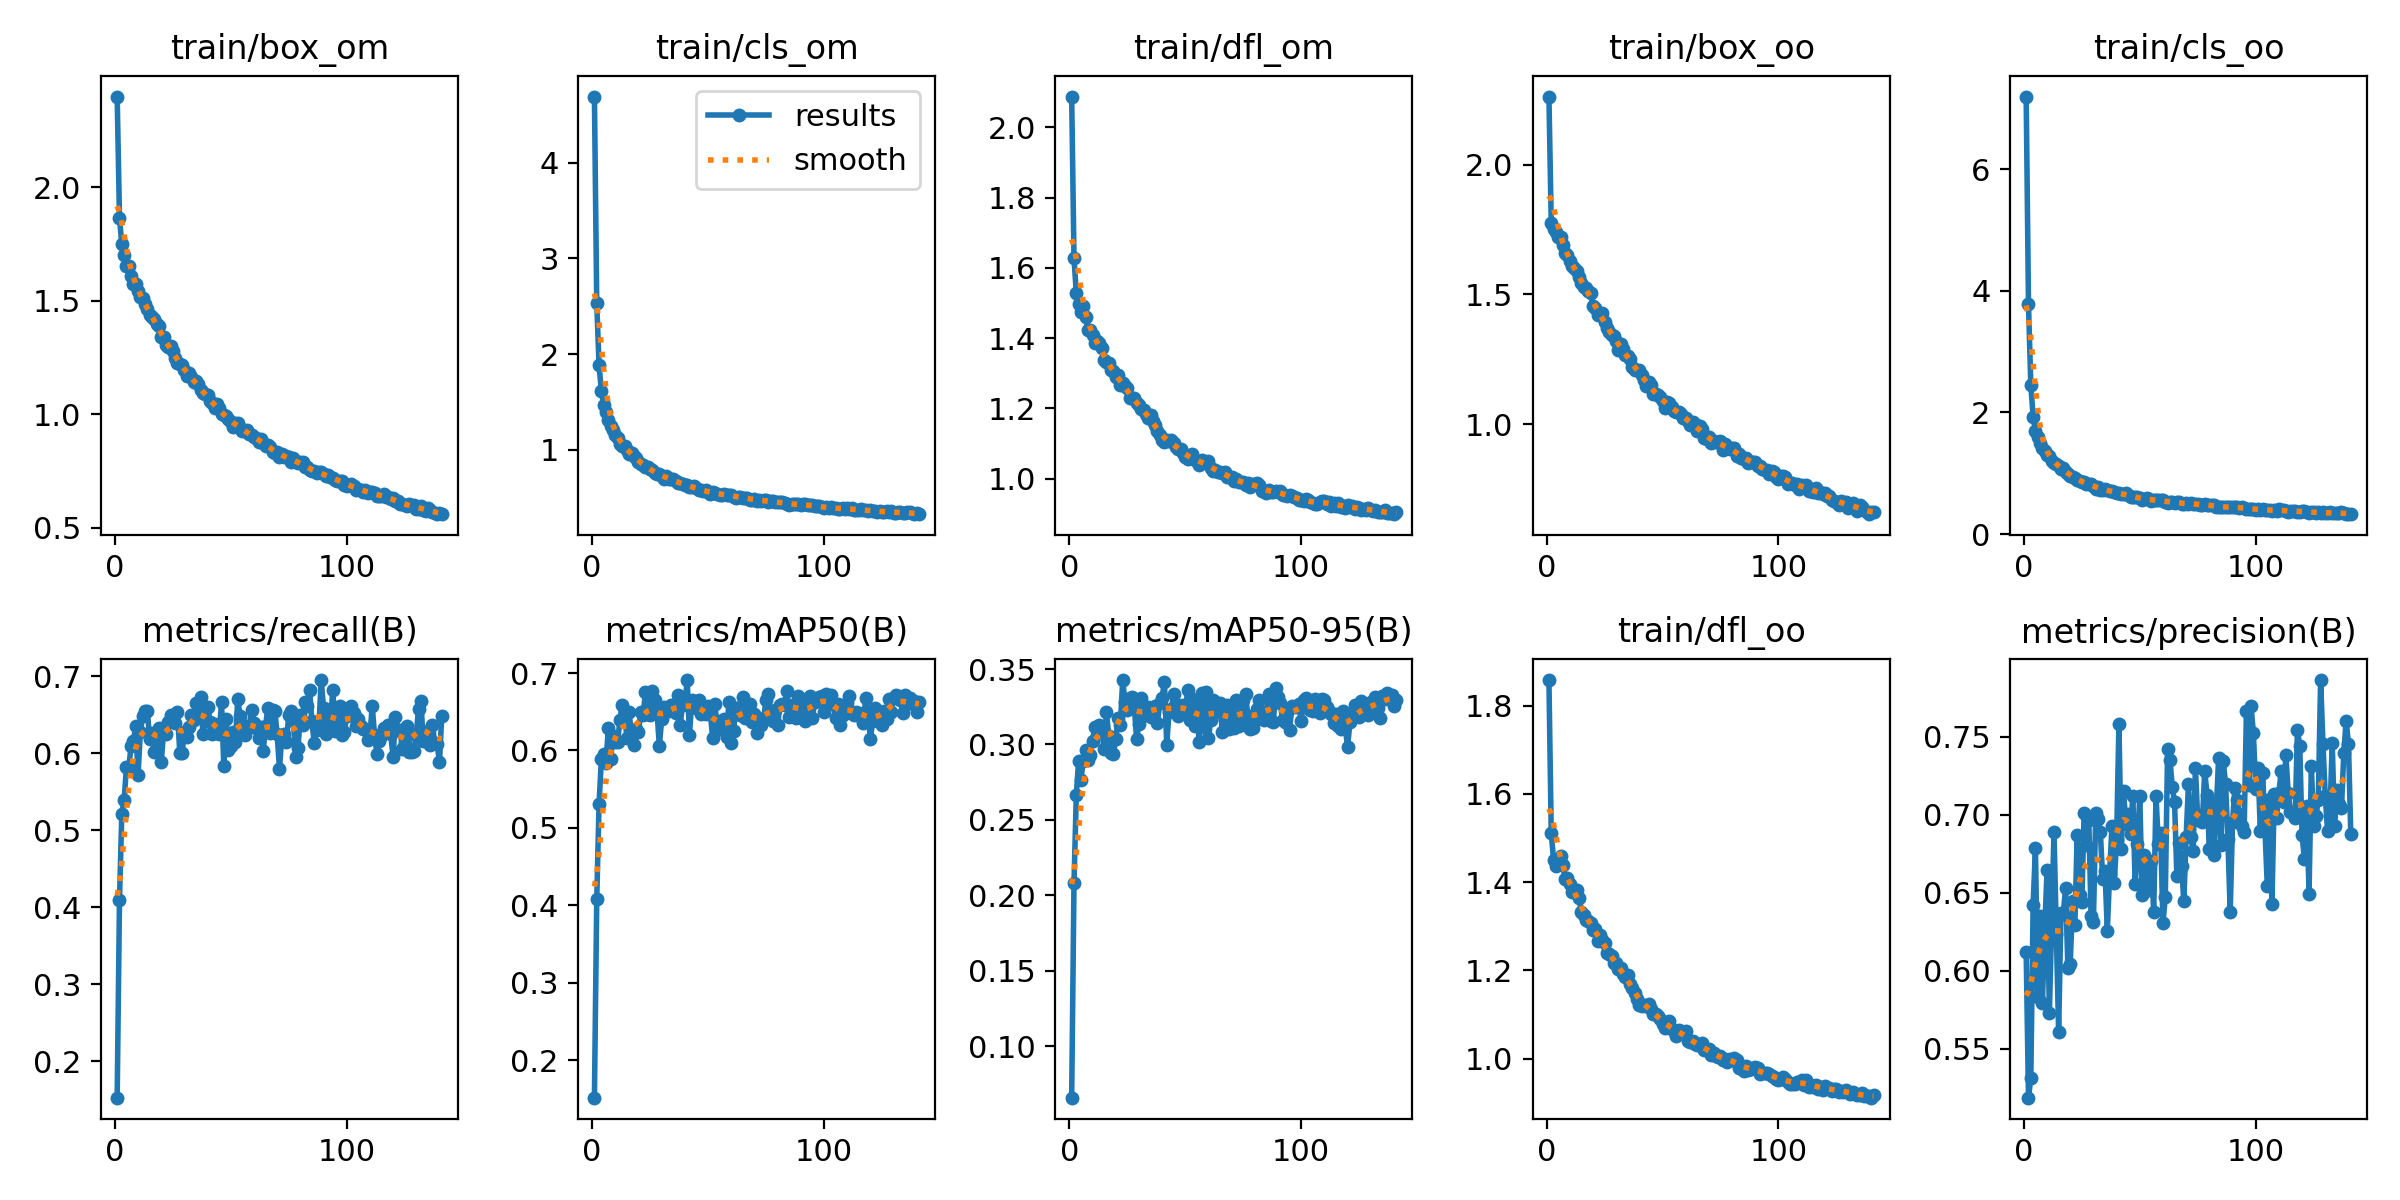

In [ ]:
#Visualise the training process
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

Model Testing

In [ ]:
#Perform prediction on testing set
model=YOLOv10(f'{HOME}/runs/detect/train/weights/best.pt')
model.predict(source='/content/drive/MyDrive/GC-10-DET/test/images', save=True)


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")



image 1/345 /content/drive/MyDrive/GC-10-DET/test/images/img_01_3402617700_01009.jpg: 320x640 1 welding_line, 1 crescent_gap, 76.4ms
image 2/345 /content/drive/MyDrive/GC-10-DET/test/images/img_01_3437011300_00918.jpg: 320x640 (no detections), 18.5ms
image 3/345 /content/drive/MyDrive/GC-10-DET/test/images/img_01_424799300_01133.jpg: 320x640 1 welding_line, 1 crescent_gap, 18.8ms
image 4/345 /content/drive/MyDrive/GC-10-DET/test/images/img_01_424799600_00002.jpg: 320x640 1 crescent_gap, 21.9ms
image 5/345 /content/drive/MyDrive/GC-10-DET/test/images/img_01_424826800_00002.jpg: 320x640 1 welding_line, 1 crescent_gap, 26.4ms
image 6/345 /content/drive/MyDrive/GC-10-DET/test/images/img_01_425000300_00630.jpg: 320x640 1 water_spot, 20.3ms
image 7/345 /content/drive/MyDrive/GC-10-DET/test/images/img_01_425005700_00156.jpg: 320x640 2 silk_spots, 19.9ms
image 8/345 /content/drive/MyDrive/GC-10-DET/test/images/img_01_425005700_00163.jpg: 320x640 1 silk_spot, 18.8ms
image 9/345 /content/drive/

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'punching_hole', 1: 'welding_line', 2: 'crescent_gap', 3: 'water_spot', 4: 'oil_spot', 5: 'silk_spot', 6: 'inclusion', 7: 'rolled_pit', 8: 'crease', 9: 'waist_folding'}
 obb: None
 orig_img: array([[[  6,   6,   6],
         [  6,   6,   6],
         [  6,   6,   6],
         ...,
         [ 65,  65,  65],
         [ 65,  65,  65],
         [ 67,  67,  67]],
 
        [[  5,   5,   5],
         [  5,   5,   5],
         [  5,   5,   5],
         ...,
         [ 65,  65,  65],
         [ 67,  67,  67],
         [ 71,  71,  71]],
 
        [[  7,   7,   7],
         [  7,   7,   7],
         [  7,   7,   7],
         ...,
         [ 65,  65,  65],
         [ 68,  68,  68],
         [ 72,  72,  72]],
 
        ...,
 
        [[  7,   7,   7],
         [  7,   7,   7],
         [  8,   8,   8],
         ...,
         [101, 101, 101],
      

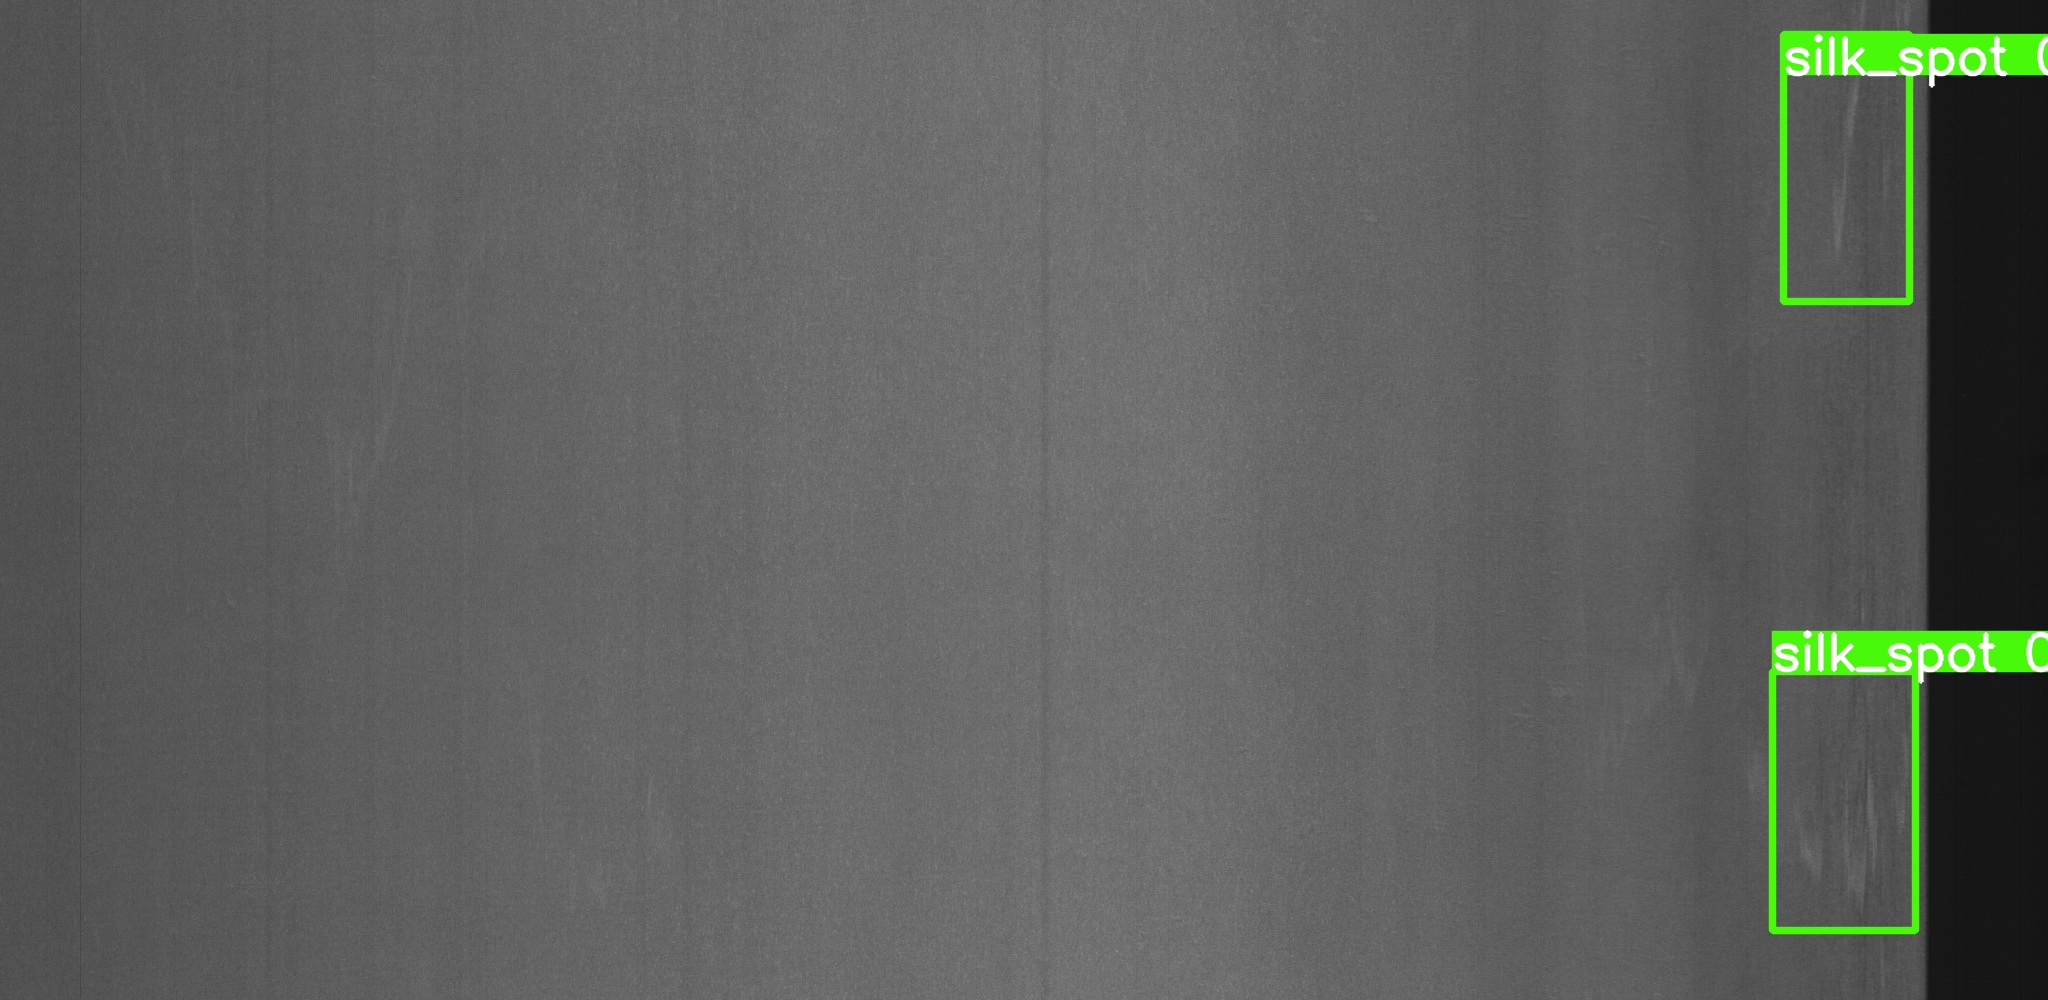

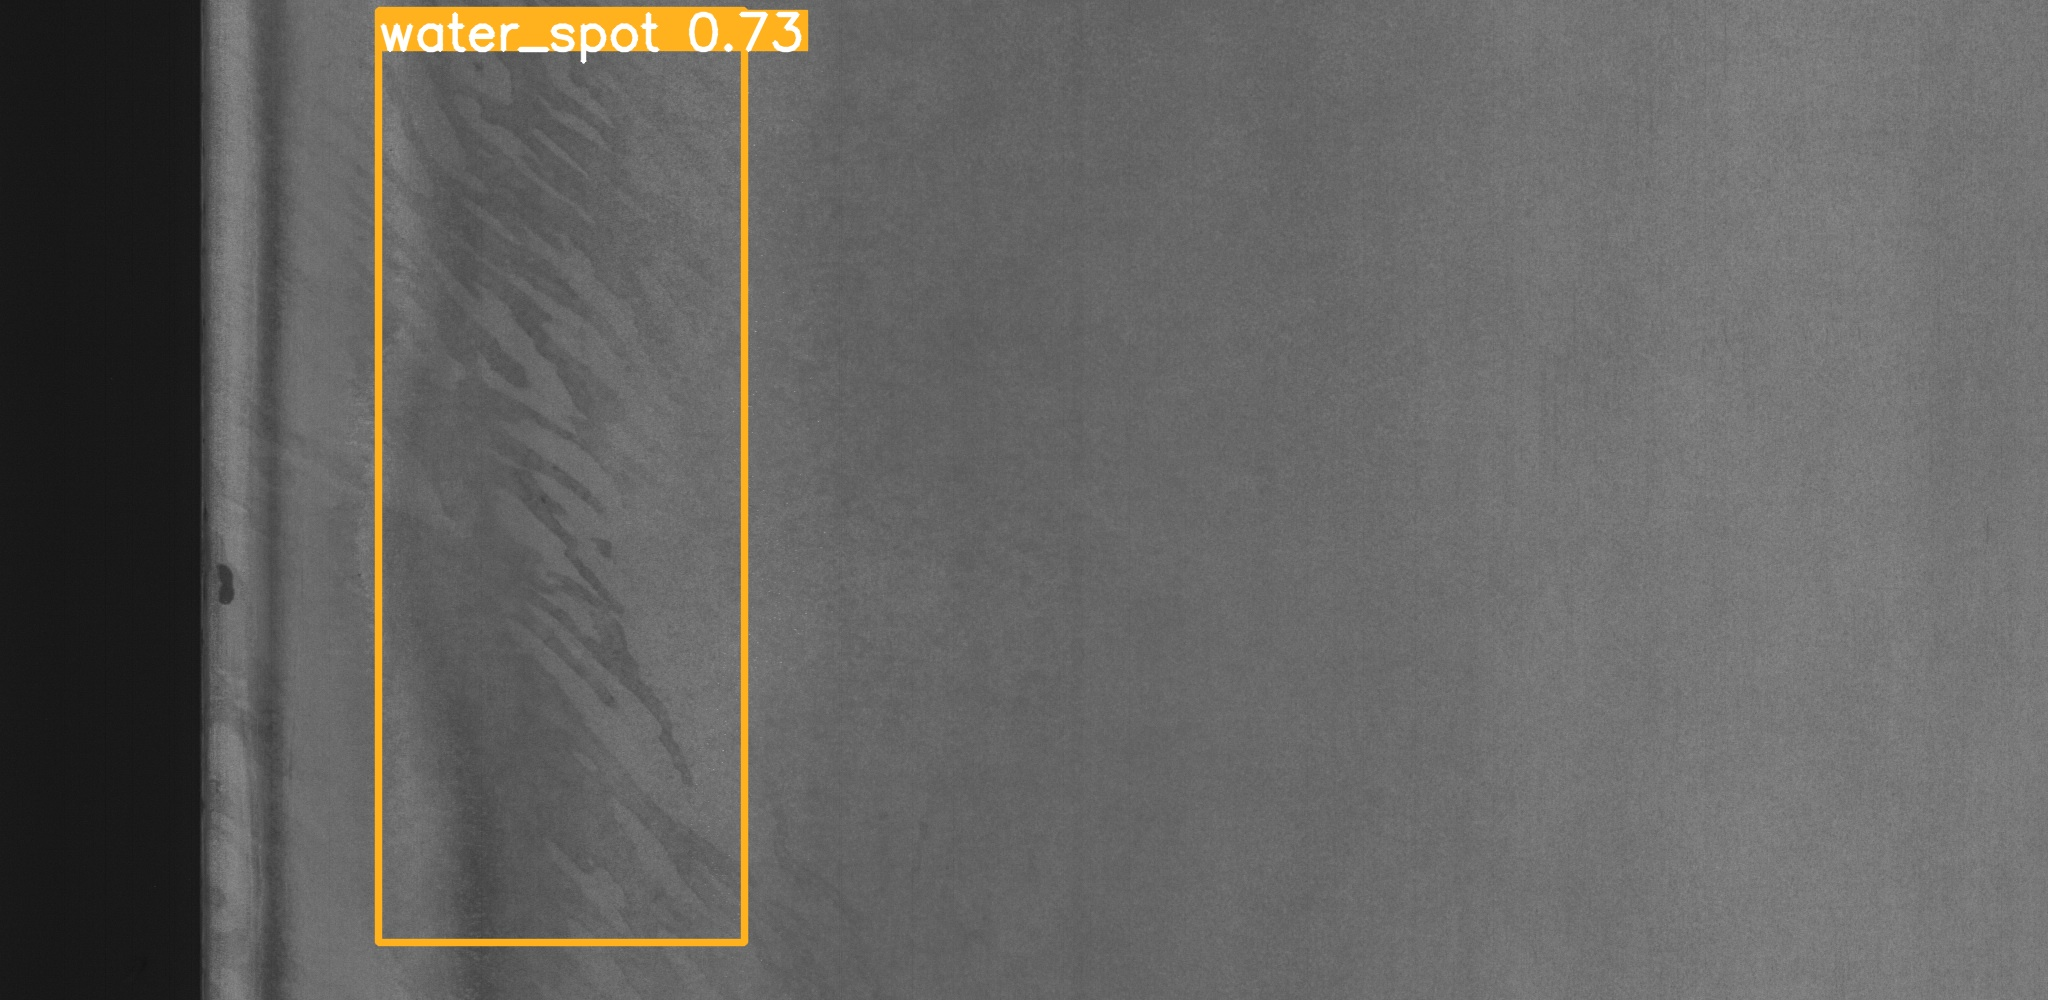

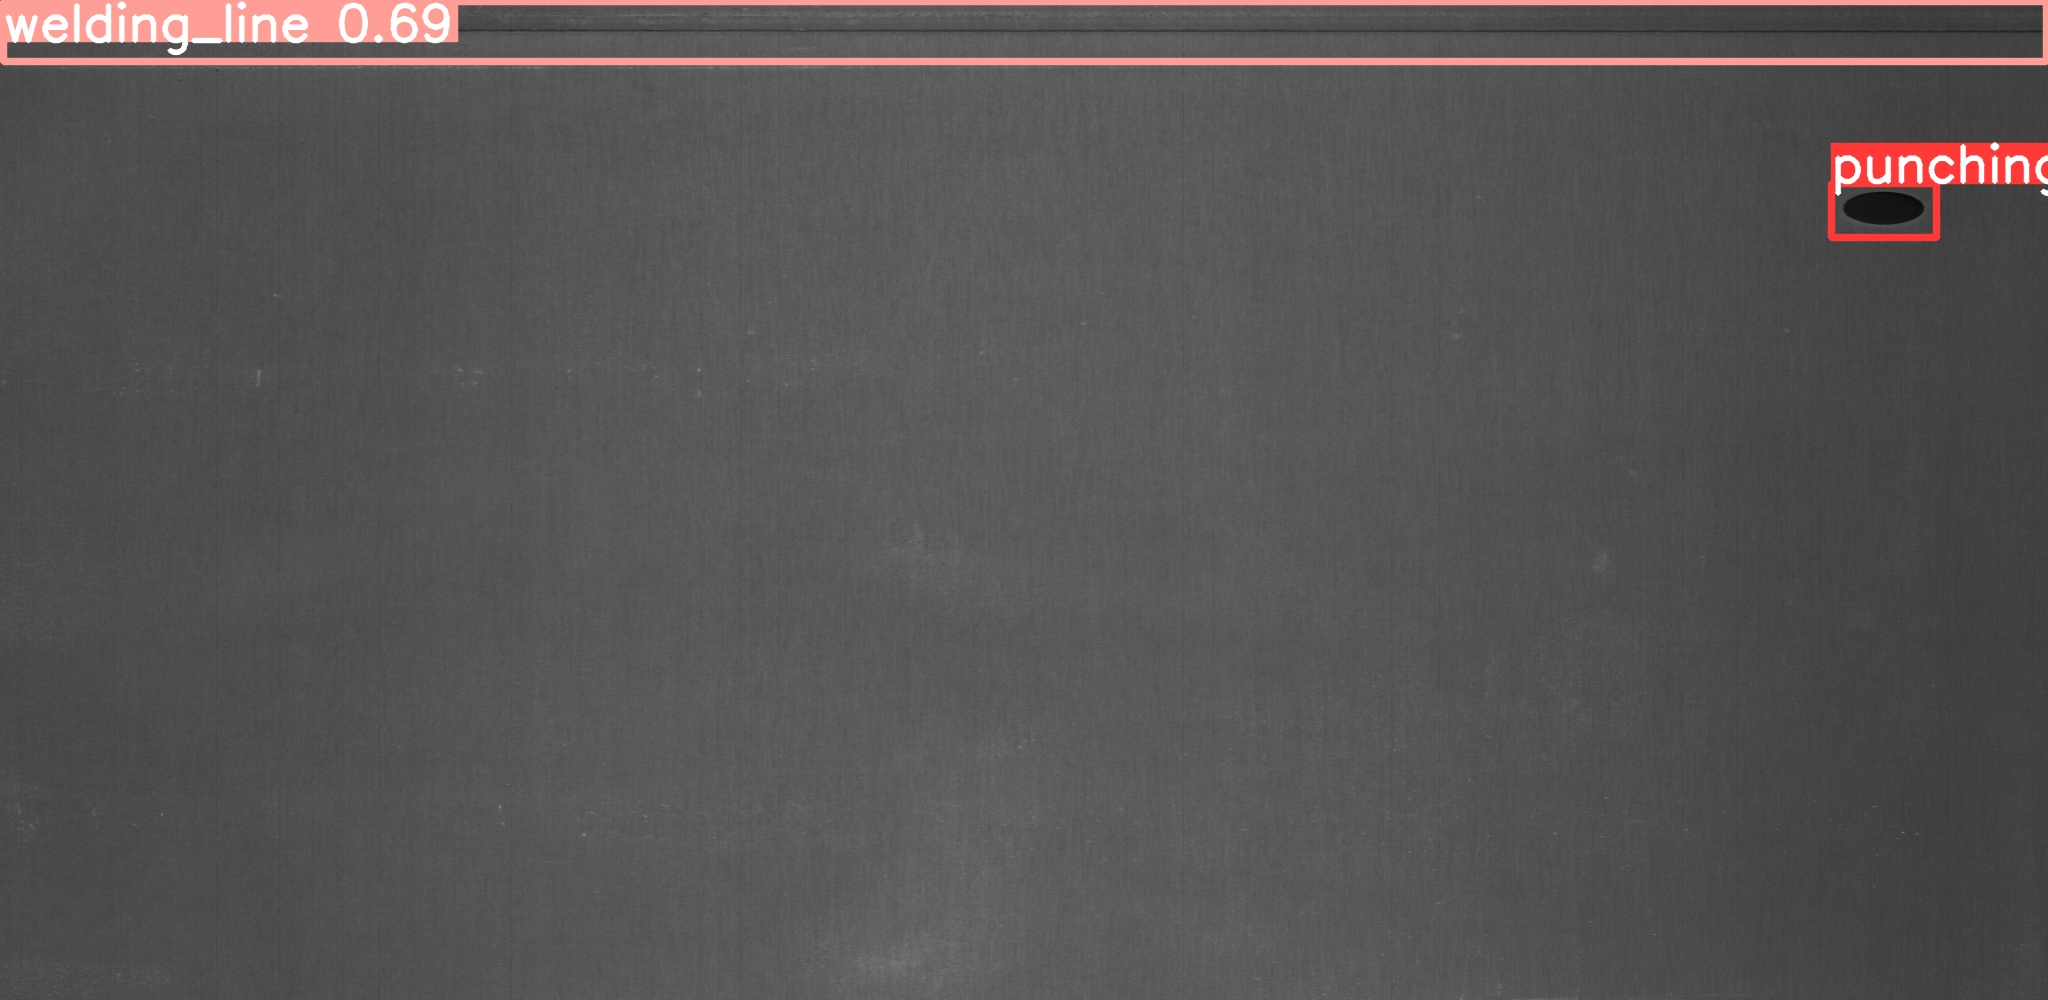

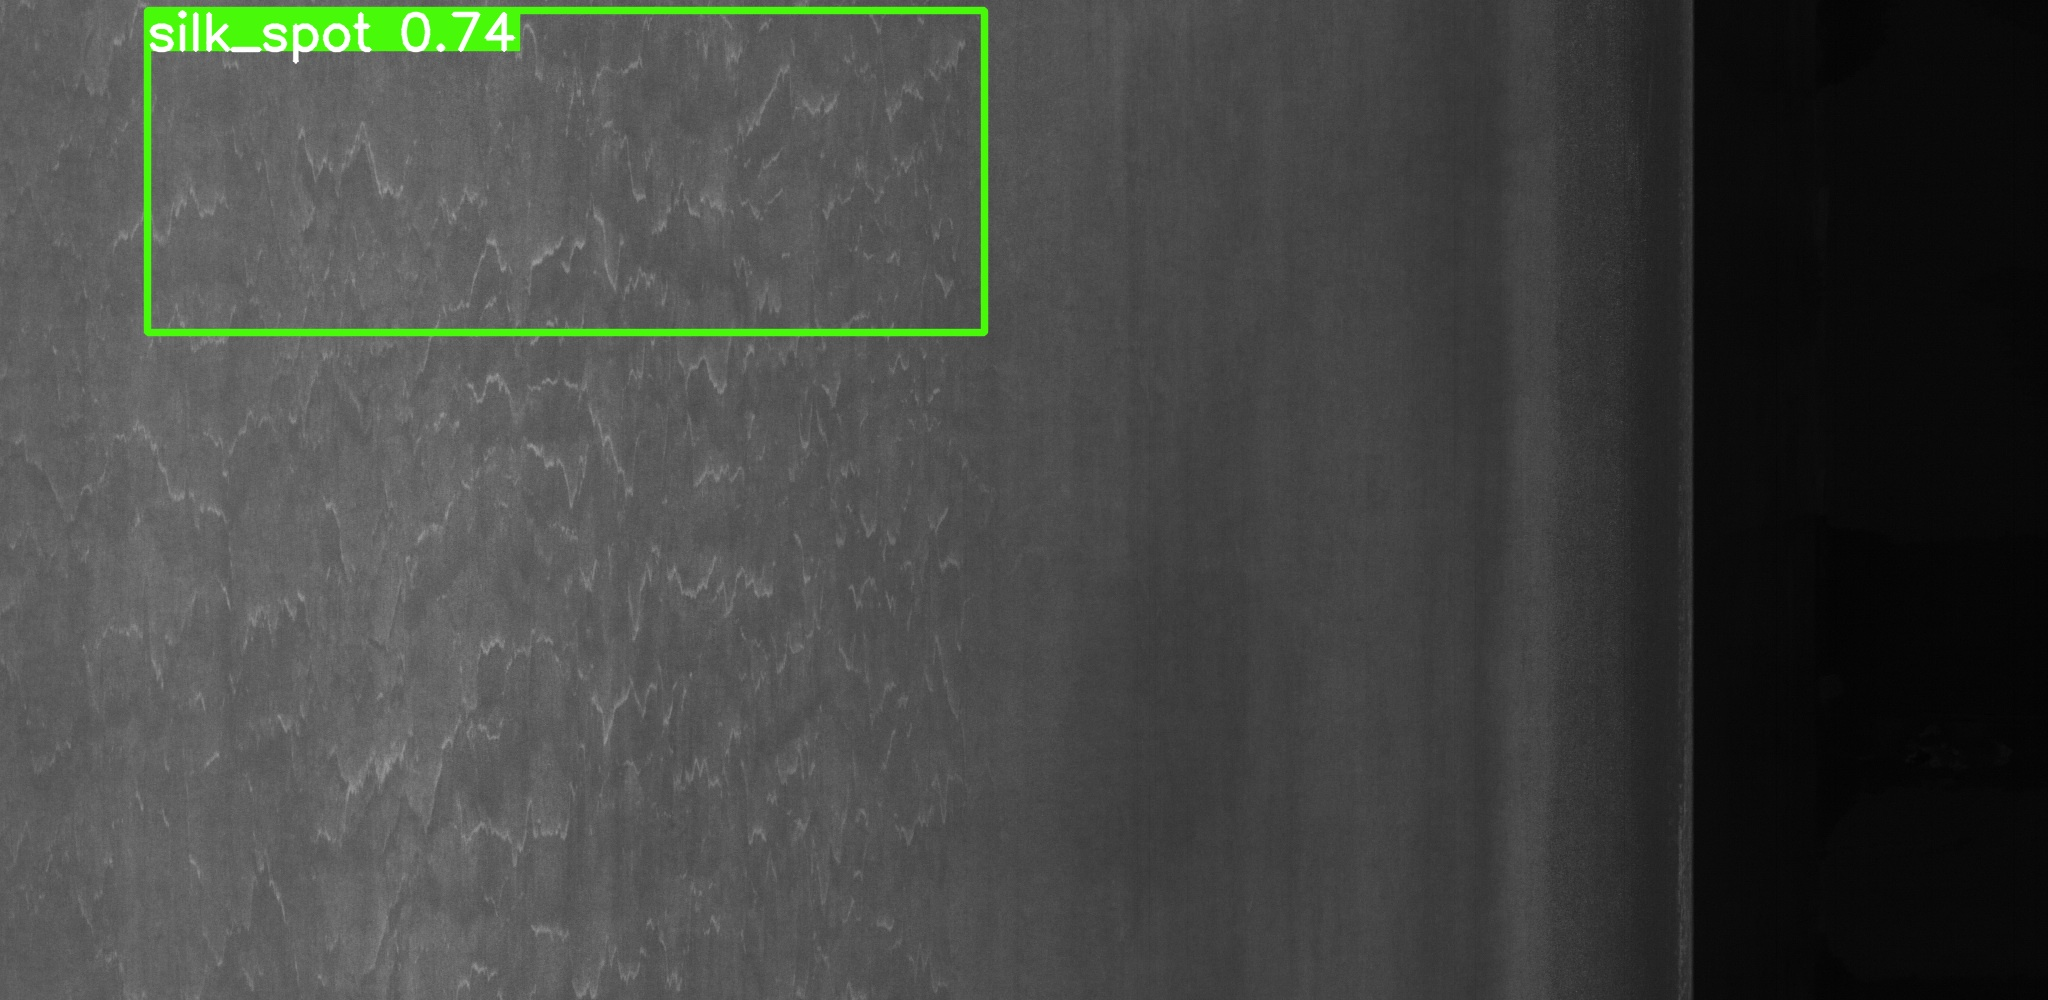

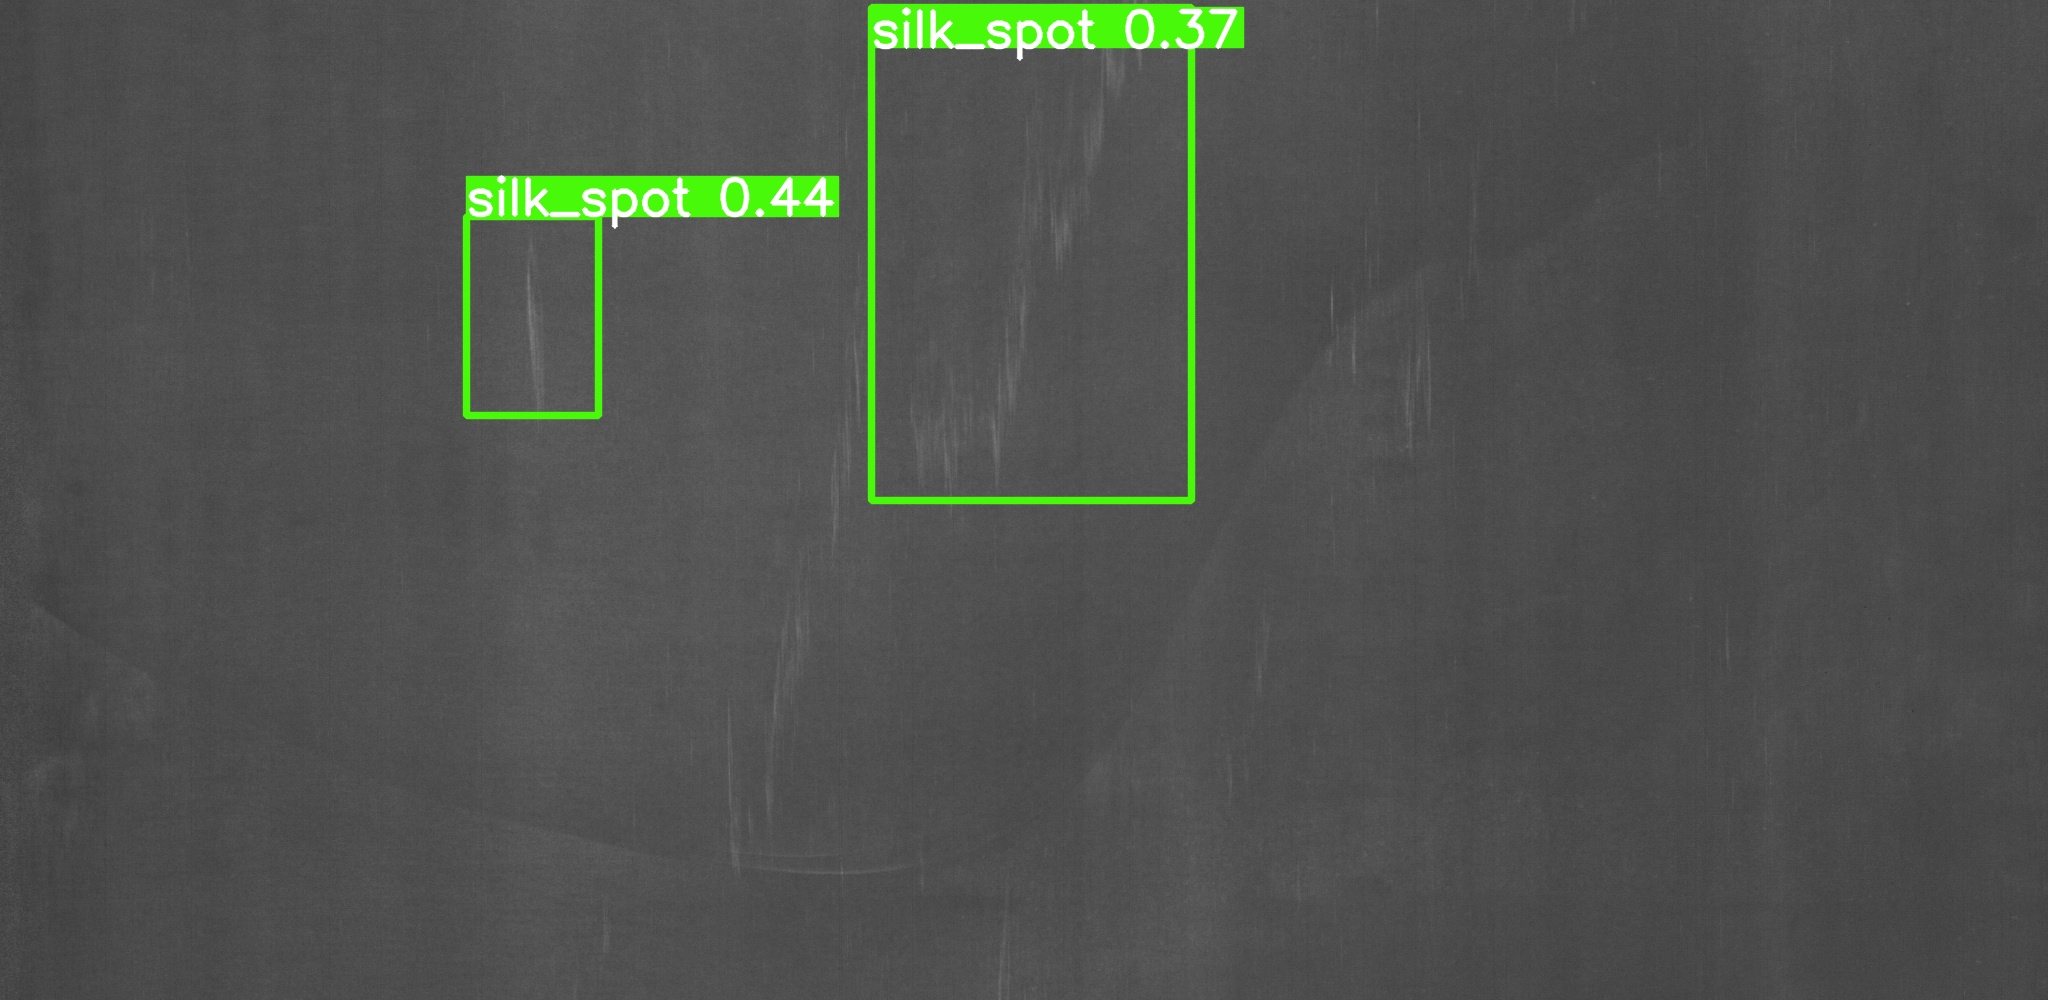

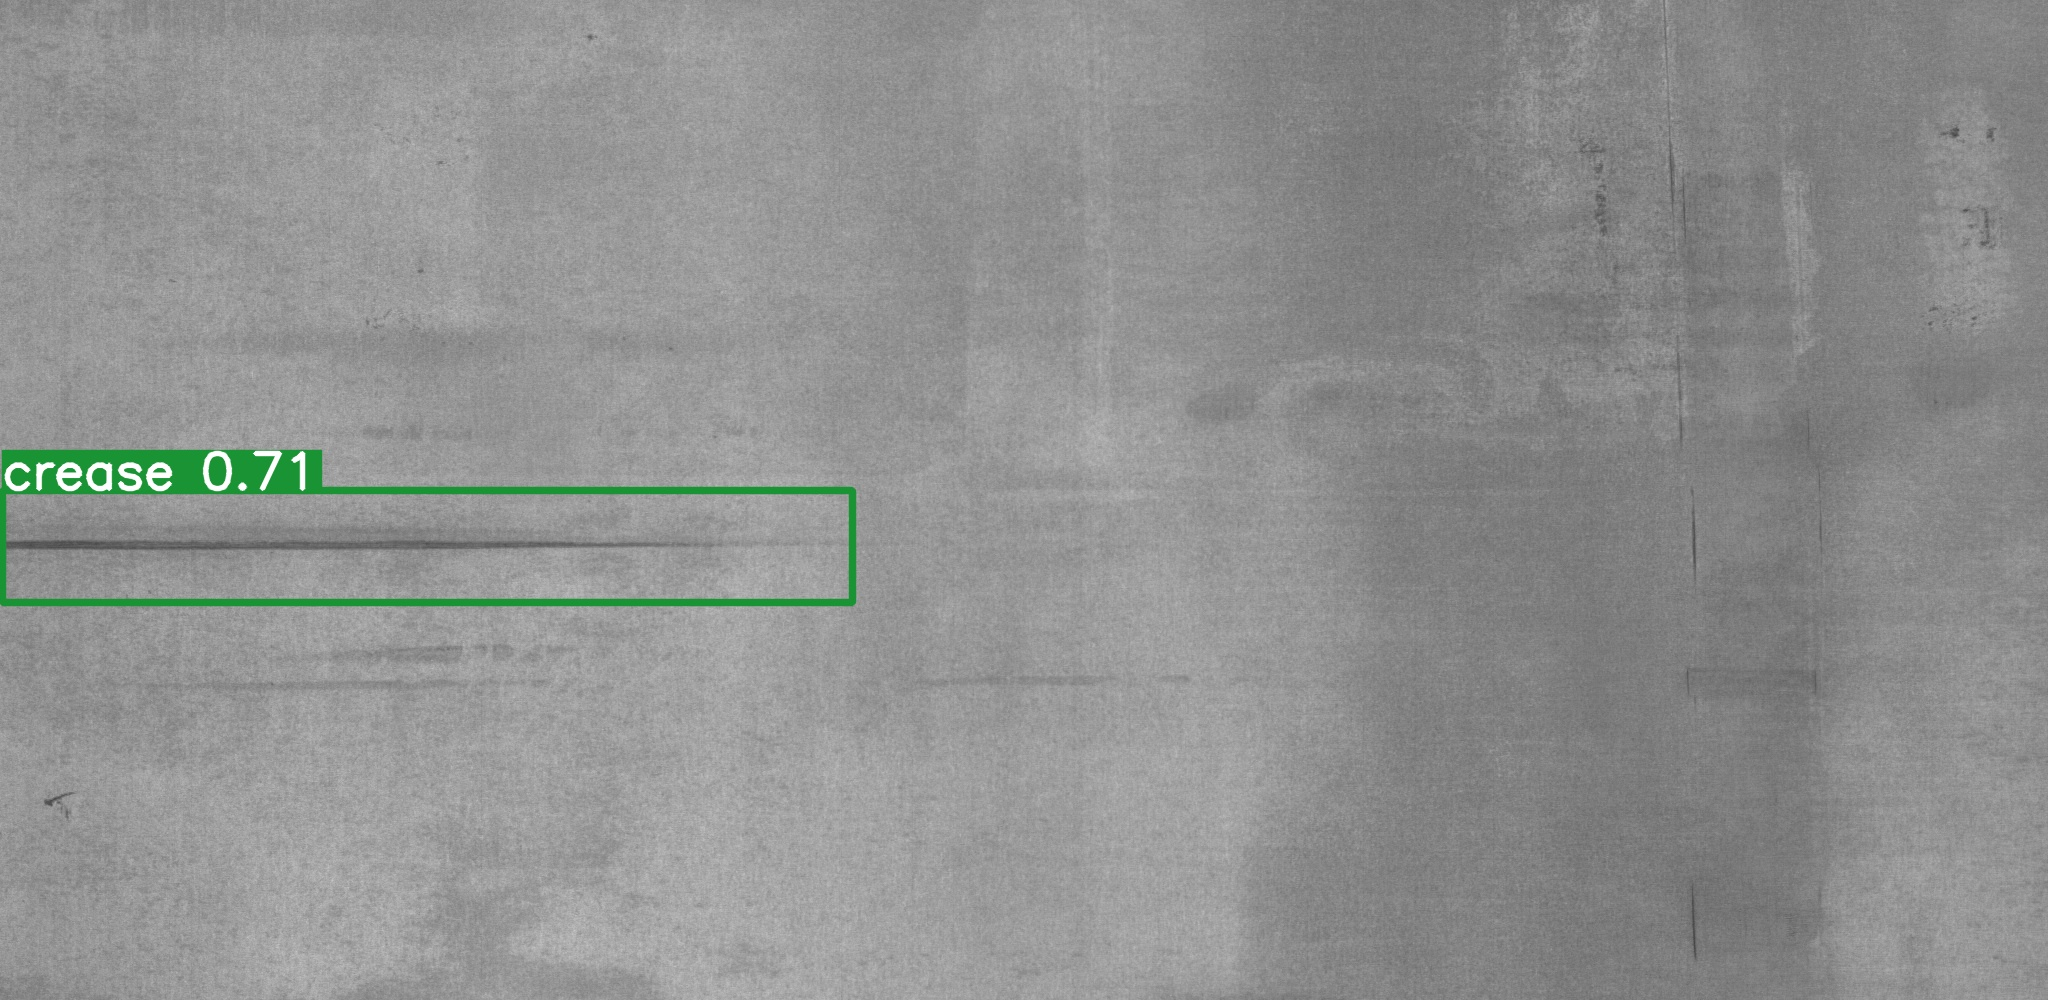

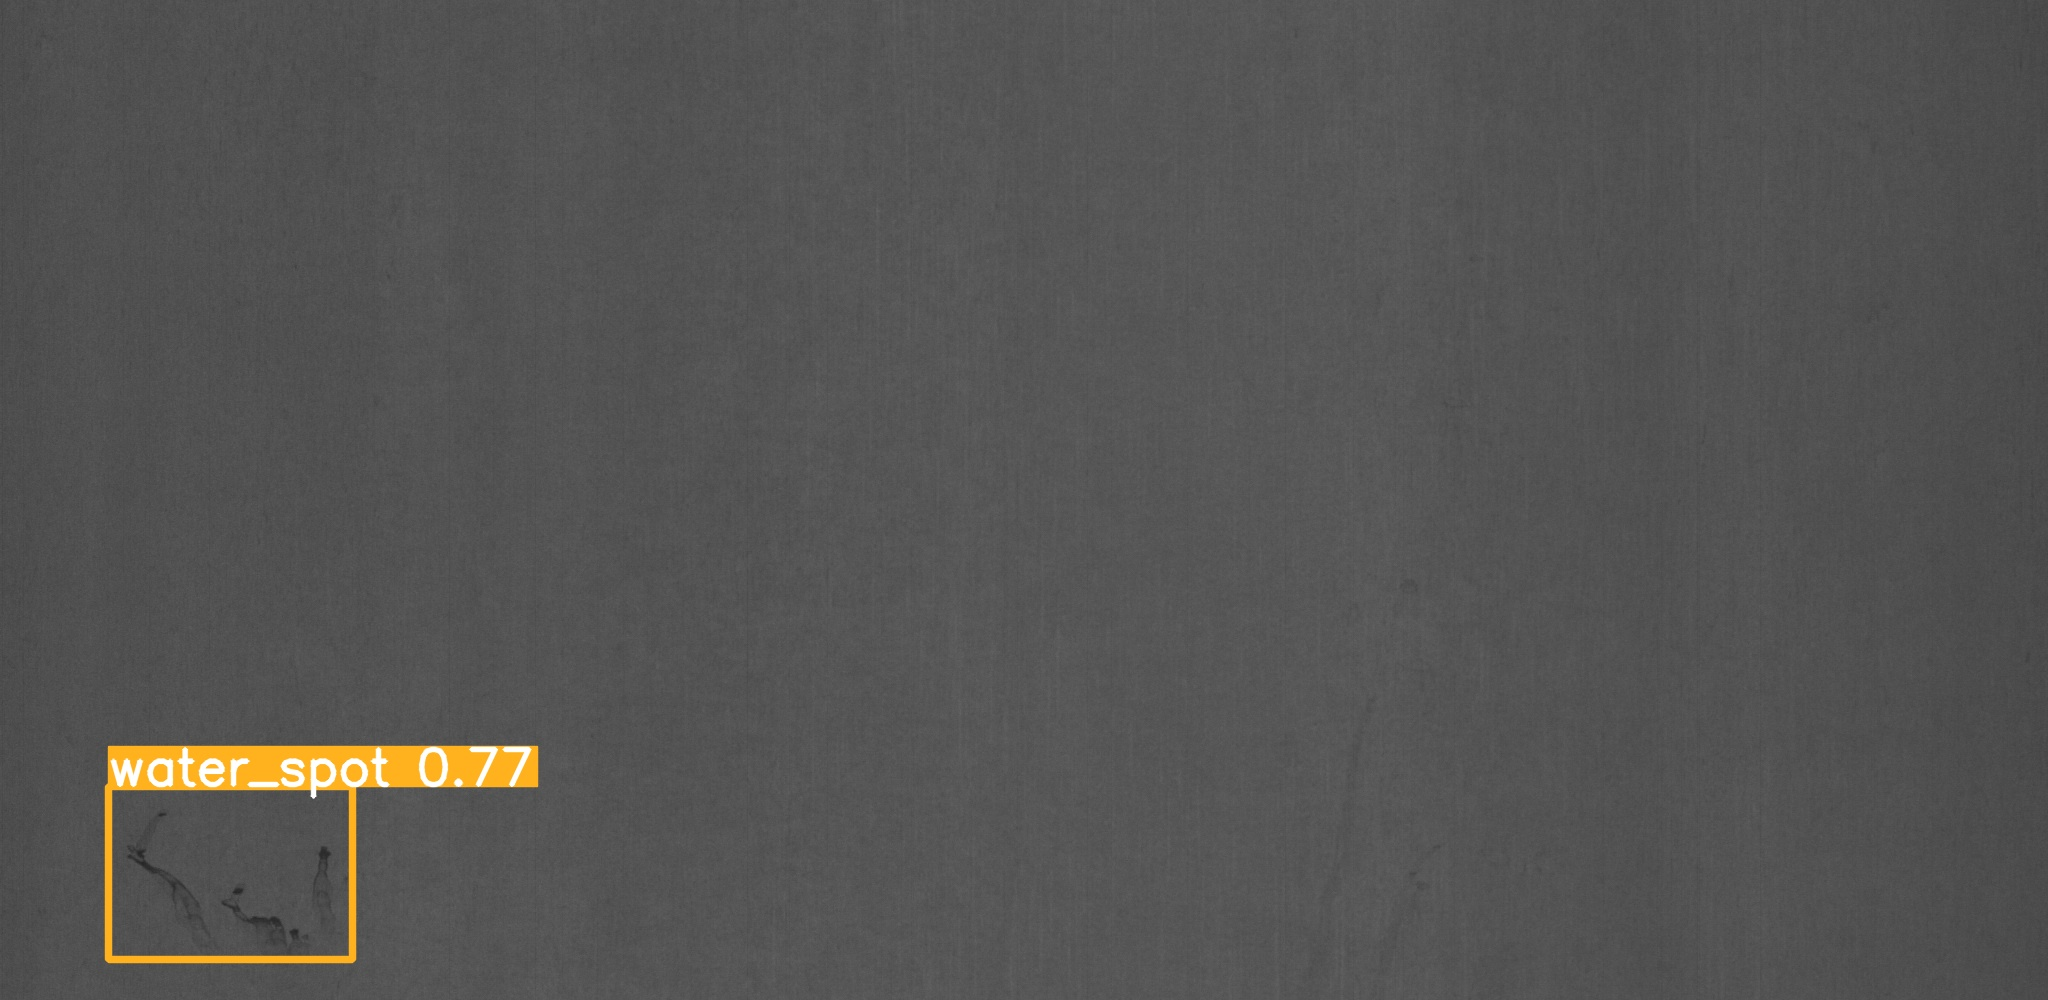

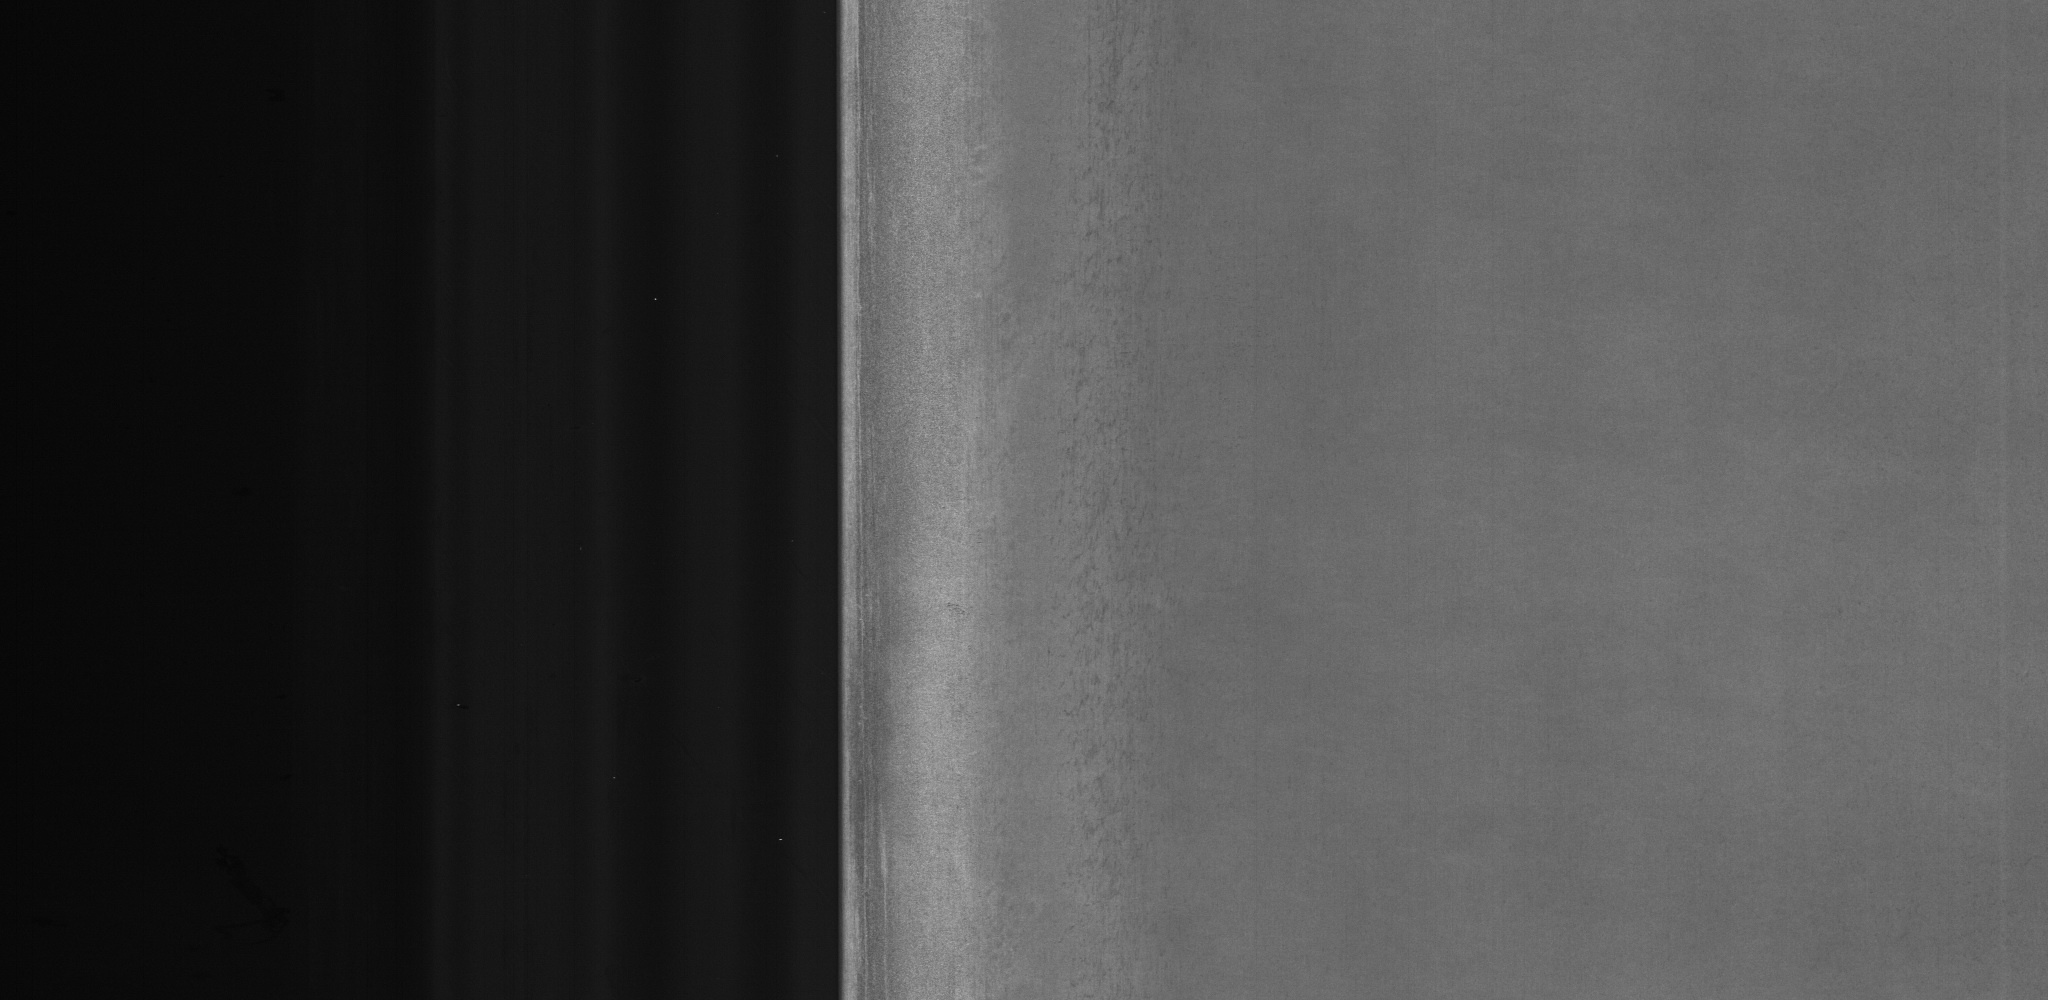

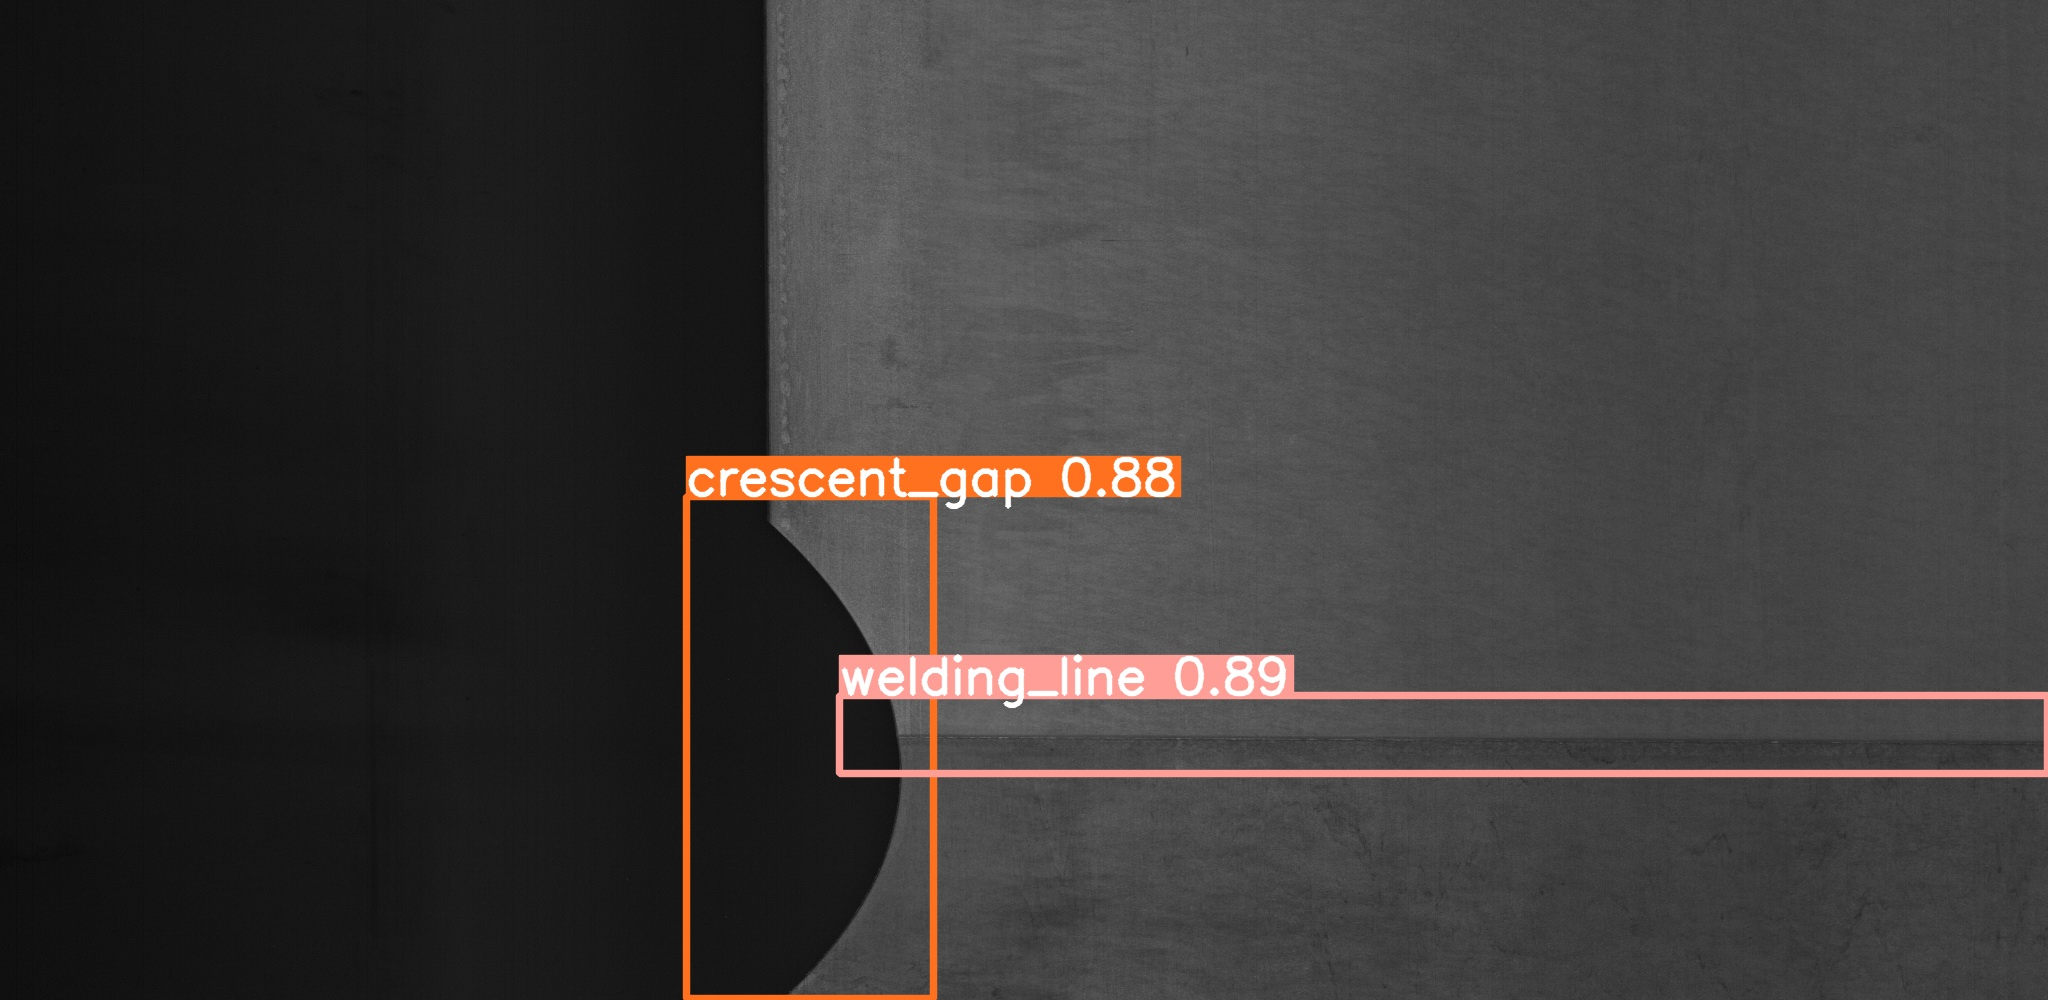

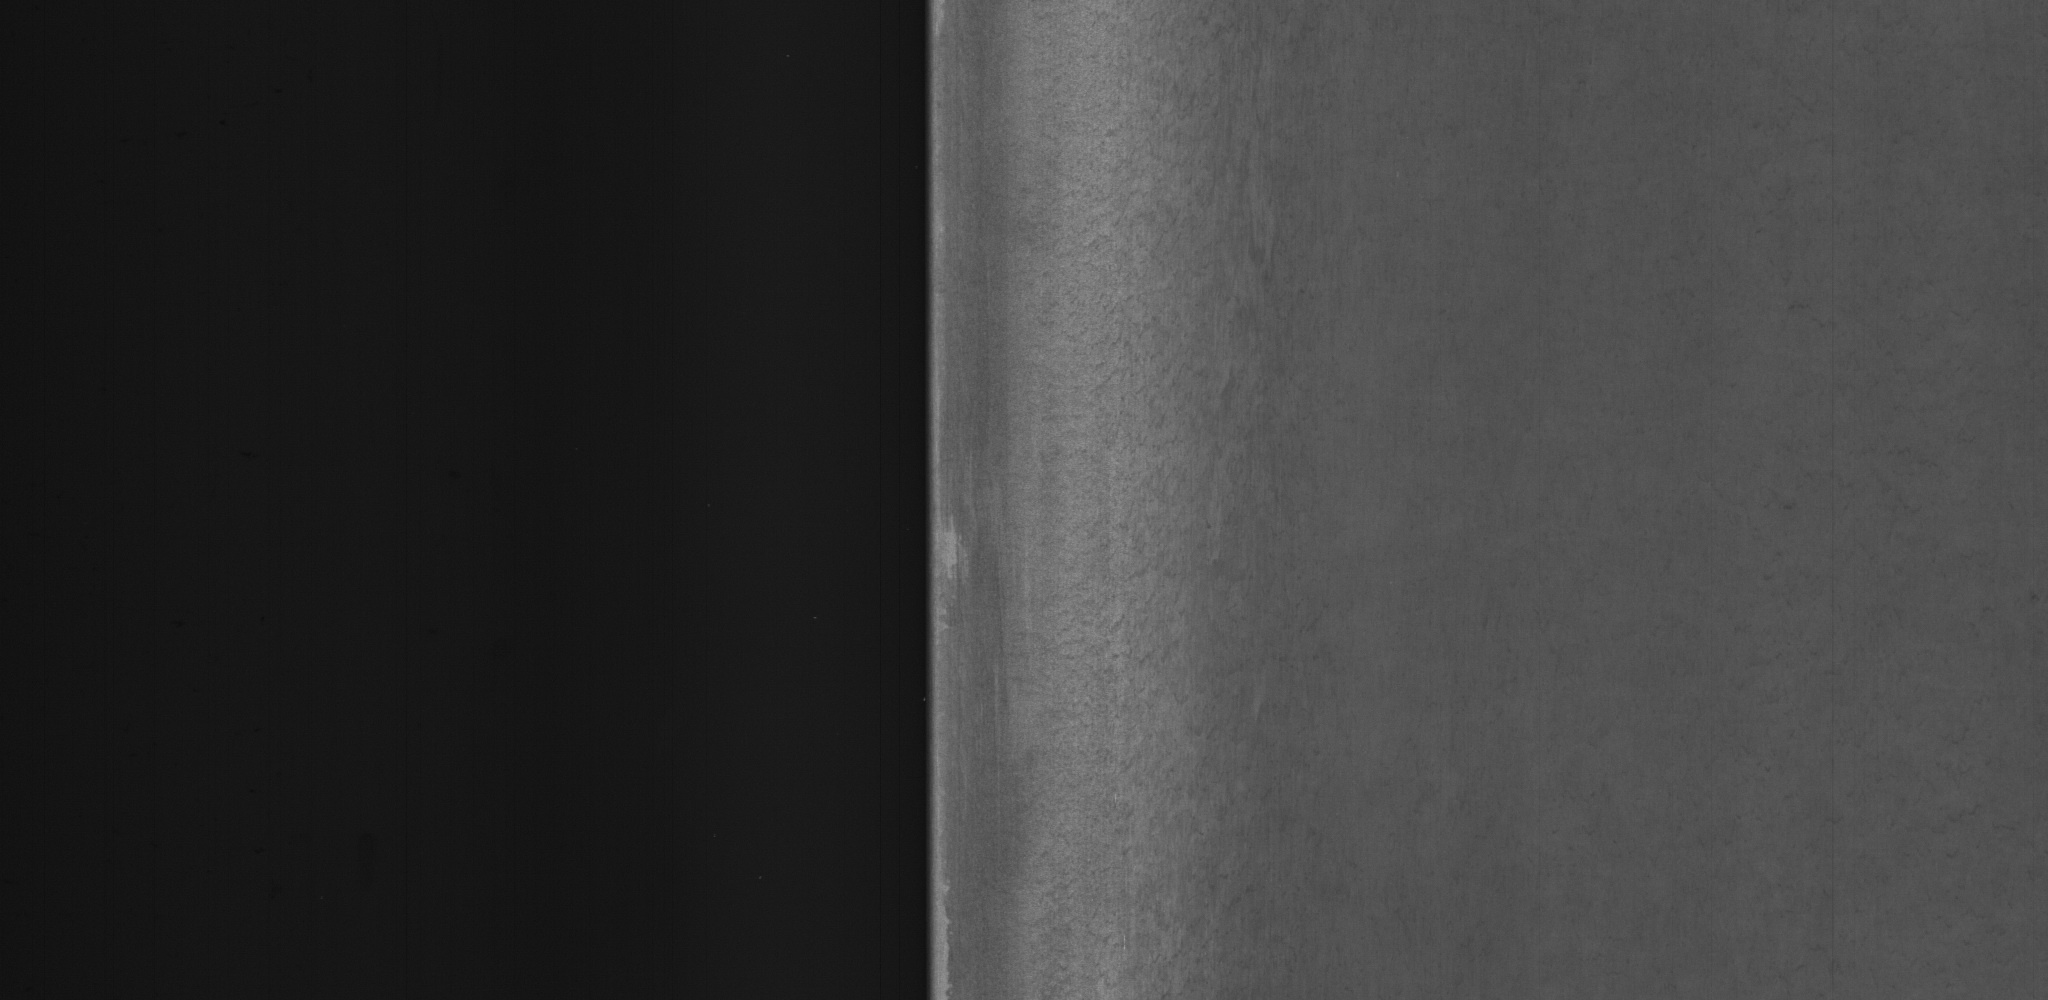

In [ ]:
#Visualzie some prediction result
for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, width=600))
  print("\n")



In [ ]:
#Evaluate trained yolov10 on testing set
test_results = model.val(imgsz=640,split='test',plots=True)

Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)


val: Scanning /content/drive/MyDrive/GC-10-DET/test/labels... 344 images, 3 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:36<00:00,  9.54it/s]


val: New cache created: /content/drive/MyDrive/GC-10-DET/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.01it/s]


                   all        345        525      0.691      0.652       0.66      0.321
         punching_hole        345         42      0.933      0.976      0.984      0.554
          welding_line        345         71      0.841      0.819       0.85      0.397
          crescent_gap        345         49      0.918       0.98      0.932      0.588
            water_spot        345         50      0.786       0.84      0.908      0.494
              oil_spot        345         84      0.515      0.571      0.578      0.219
             silk_spot        345        136      0.595      0.562      0.528      0.202
             inclusion        345         52       0.38      0.404       0.32      0.112
            rolled_pit        345          9      0.727      0.222      0.318      0.205
                crease        345          6      0.565        0.5      0.529       0.12
         waist_folding        345         26      0.652      0.649      0.655      0.314
Speed: 0.4ms preproce

Visualise testing result

In [ ]:
#F1 curve
Image(filename=f'{HOME}/runs/detect/val/F1_curve.png', width=600)

In [ ]:
#Precision-recall curve
Image(filename=f'{HOME}/runs/detect/val/PR_curve.png', width=600)

In [ ]:
#Precision-confidence curve
Image(filename=f'{HOME}/runs/detect/val/P_curve.png', width=600)

In [ ]:
#Recall-confidence curve
Image(filename=f'{HOME}/runs/detect/val/R_curve.png', width=600)

In [ ]:
#Confusion matrix
Image(filename=f'{HOME}/runs/detect/val/confusion_matrix.png', width=600)

In [ ]:
#Normalised confusion matrix
Image(filename=f'{HOME}/runs/detect/val/confusion_matrix_normalized.png', width=600)

Compare actual defect labels with model predictions

In [ ]:
#Defect labels for testing batch 0
Image(filename=f'{HOME}/runs/detect/val/val_batch0_labels.jpg', width=600)

In [ ]:
#Model prediction on testing batch 0
Image(filename=f'{HOME}/runs/detect/val/val_batch0_pred.jpg', width=600)

In [ ]:
#Defect labels on testing batch 1
Image(filename=f'{HOME}/runs/detect/val/val_batch1_labels.jpg', width=600)

In [ ]:
#Model prediction on testing batch 1
Image(filename=f'{HOME}/runs/detect/val/val_batch1_pred.jpg', width=600)

In [ ]:
#Defect labels on testing batch 2
Image(filename=f'{HOME}/runs/detect/val/val_batch2_labels.jpg', width=600)

In [ ]:
#Model prediction on testing batch 2
Image(filename=f'{HOME}/runs/detect/val/val_batch2_pred.jpg', width=600)

Save the experimental data

In [ ]:
#Export the model
model.export(format='onnx')

Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from '/content/runs/detect/train4/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (31.9 MB)

ONNX: starting export with onnx 1.16.2 opset 17...
ONNX: export success ✅ 2.2s, saved as '/content/runs/detect/train4/weights/best.onnx' (58.7 MB)

Export complete (4.1s)
Results saved to /content/runs/detect/train4/weights
Predict:         yolo predict task=detect model=/content/runs/detect/train4/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/content/runs/detect/train4/weights/best.onnx imgsz=640 data=/content/Metal-surface-detection-using-NEU-8/data.yaml  
Visualize:       https://netron.app


'/content/runs/detect/train4/weights/best.onnx'

In [ ]:
#Save all the model file into my google drive
!cp -r /content/runs /content/drive/MyDrive/YOLOv10_result_GC10-DET/